In [ ]:
!pip install peartree
!pip install osmnx
!pip install ripser
!pip install persim

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import peartree as pt
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import numpy as np
import os
import pandas as pd
import csv
from ripser import ripser
from persim import plot_diagrams
import math
%matplotlib inline

In [5]:
path = '/content/drive/MyDrive/GTFS/Local_Transit'

In [10]:
def compute_euclidean_distance(x1,y1,x2,y2):
  return math.sqrt((x2-x1)**2 + (y2-y1)**2)


def create_transit_graph(path, city_name):
    # Initialize an empty directed graph
    transit_graph = nx.DiGraph()

    # Create dictionaries to store stop and parent_station information
    stop_dict = {}
    parent_station_dict = {}

    # Load stops.txt to populate the dictionaries
    stops_file = open(path + '/stops.txt', 'r', encoding='utf-8-sig')
    stops_reader = csv.reader(stops_file)
    next(stops_reader)  # Skip the header row

    for stop in stops_reader:
        stop_name = stop[0]
        parent_station = stop[1]
        stop_id = stop[2]
        latitude = float(stop[3])
        longitude = float(stop[4])

        if stop_name.startswith(city_name):
            stop_dict[stop_id] = (stop_name, latitude, longitude)
            if parent_station:
                parent_station_dict[stop_id] = parent_station

    # Load stop_times.txt to create nodes and edges in the transit graph
    stop_times_file = open(path + '/stop_times.txt', 'r', encoding='utf-8-sig')
    stop_times_reader = csv.reader(stop_times_file)
    next(stop_times_reader)  # Skip the header row

    for stop_time in stop_times_reader:
        stop_id = stop_time[3]
        trip_id = stop_time[0]

        if stop_id in stop_dict:
            transit_graph.add_node(stop_id)
            parent_station = parent_station_dict.get(stop_id)

            if parent_station:
                transit_graph.add_node(parent_station)
                parent_station_info = stop_dict.get(parent_station)
                stop_info = stop_dict.get(stop_id)

                if parent_station_info and stop_info:
                  edge_weight = compute_euclidean_distance(parent_station_info[1], parent_station_info[2], stop_info[1], stop_info[2])
                  transit_graph.add_edge(parent_station, stop_id, trip_id=trip_id, weight=edge_weight)

    # Close the GTFS files
    stops_file.close()
    stop_times_file.close()

    dist_mat = nx.floyd_warshall_numpy(transit_graph)
    result = ripser(dist_mat, distance_matrix=True)
    persistence_diagram = result['dgms']

    return transit_graph, persistence_diagram

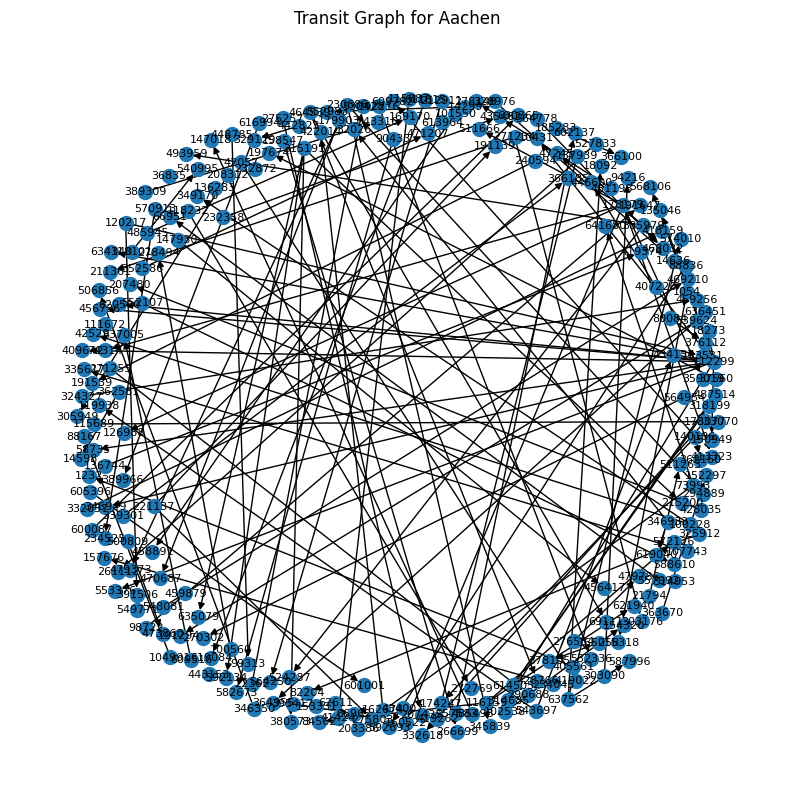

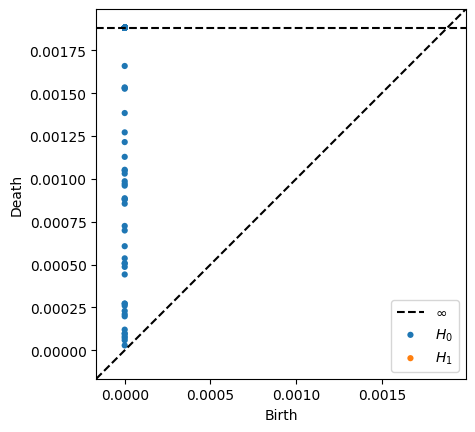

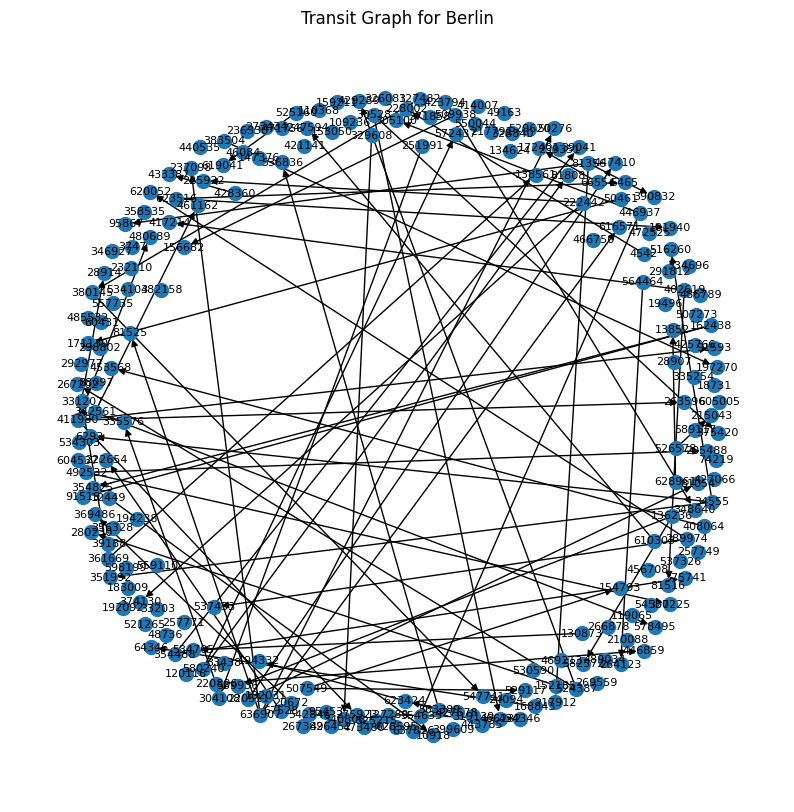

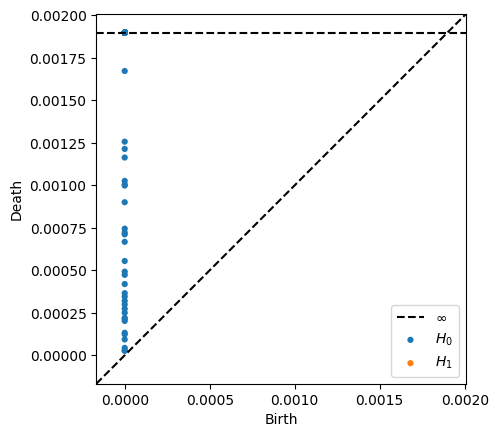

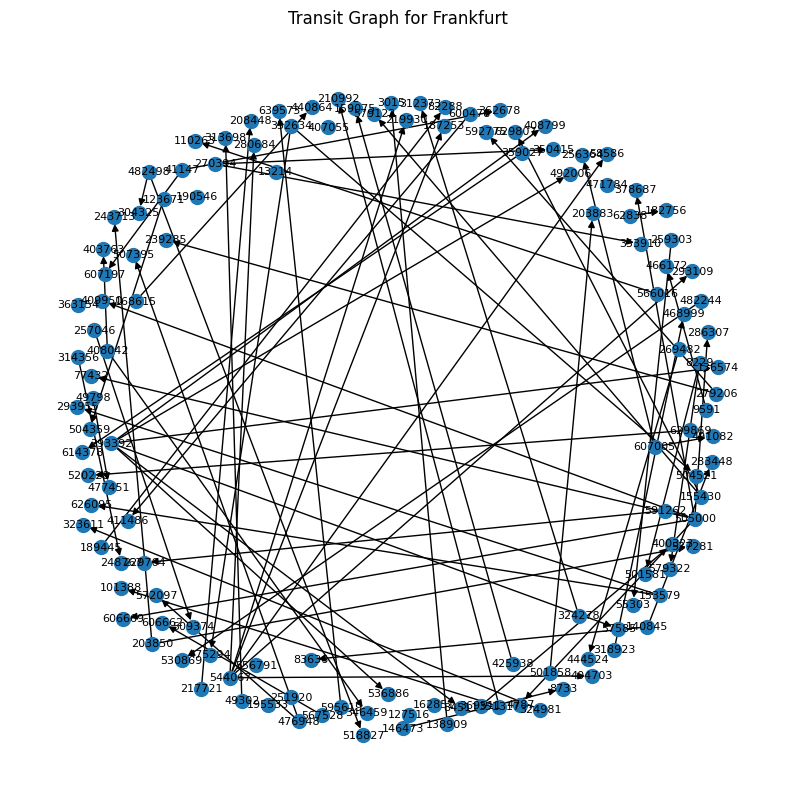

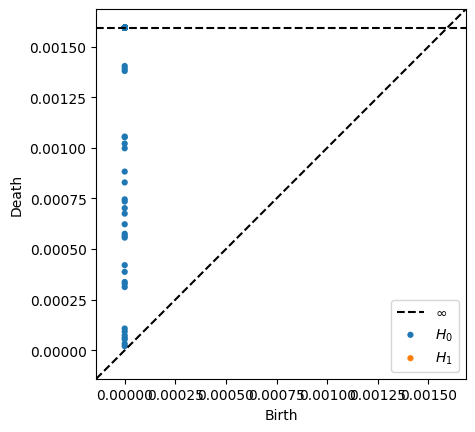

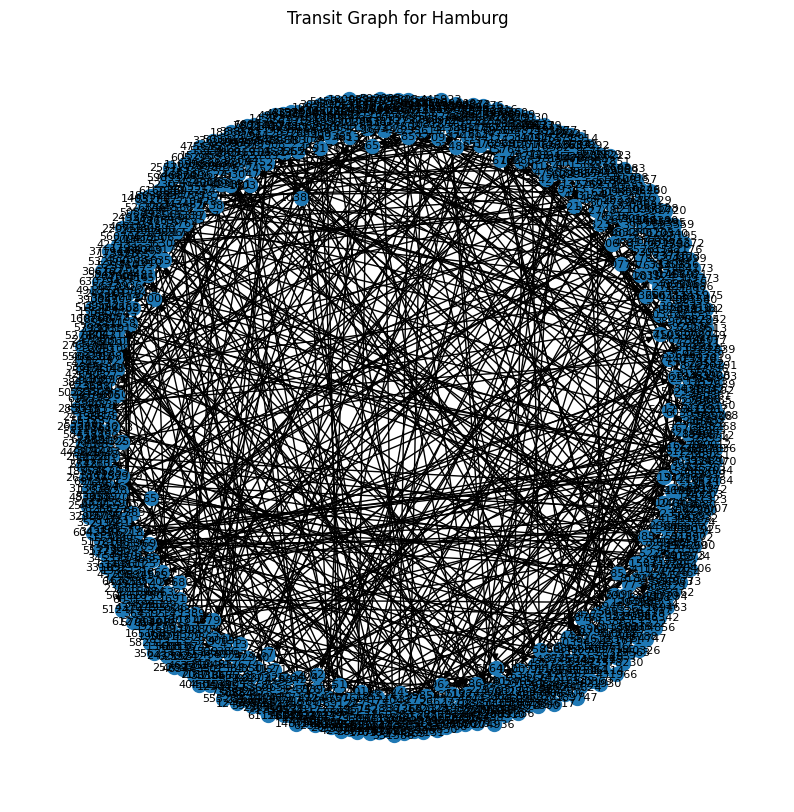

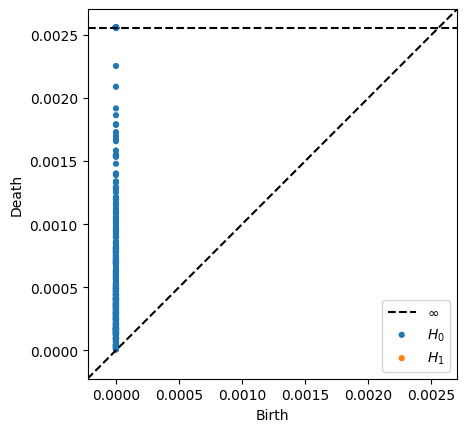

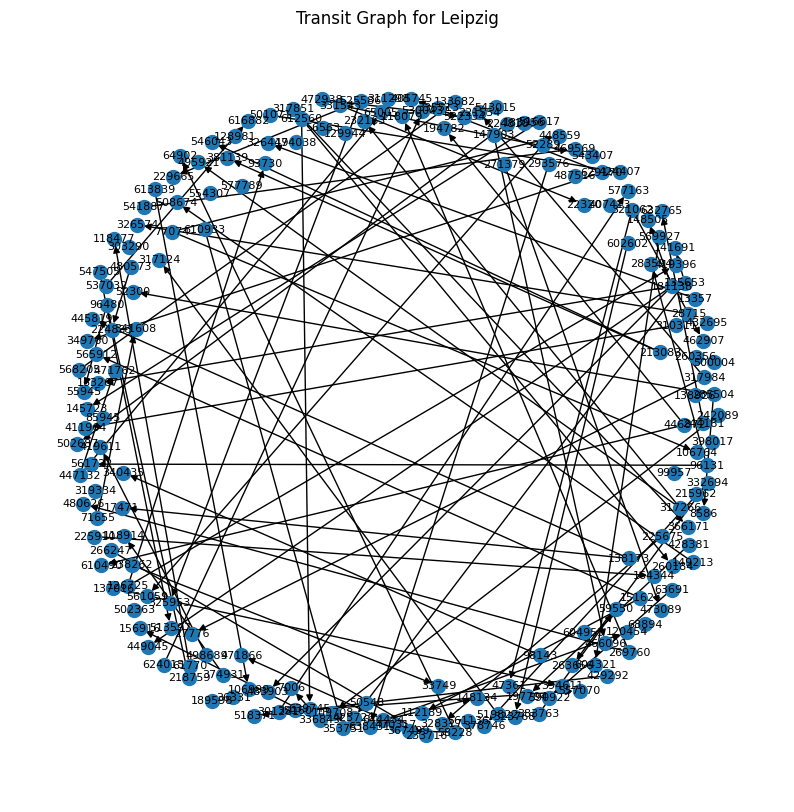

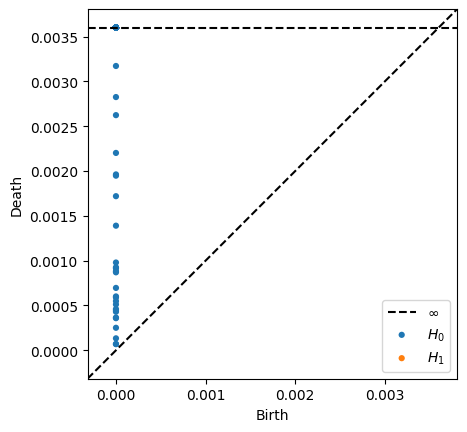

In [11]:
cities = ['Aachen', 'Berlin', 'Frankfurt', 'Hamburg', 'Leipzig']
for city_name in cities:
  transit_graph, persistence_diagram = create_transit_graph(path, city_name)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(transit_graph, k=0.5)
  nx.draw_networkx(transit_graph, pos, with_labels=True, node_size=100, font_size=8)
  plt.title(f"Transit Graph for {city_name}")
  plt.axis('off')
  plt.show()

  plot_diagrams(persistence_diagram)